<a href="https://colab.research.google.com/github/tiasondjaja/circular_societies/blob/master/Circular_Societies_Examples_and_Visualization-Google_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Circular Societies Visualization Tool

In this document, we define:
+ The `Set` class (to create approval sets)
+ The `CircularSociety` class (to create a circular society, which is made up of approval sets)
    + Along with methods for visualizing the circular societies, computing piercing number and approval number, checking (k, m)-agreeability, and transforming the society into Hardin's uniform society.
+ Functions to randomly generate circular societies.

A complete "documentation" and a couple of examples are included below (scroll down).


### How to run and use this document
+ First, run the code cell in the "Setup" section below.  Do not modify anything.
+ Then, optionally, read the documentation and run the code cells in the "Example" section
+ Experiment with your own circular societies

## Setup

Run the code cell in the "Setup" section below once each time the notebook is started. Do not modify anything.

In [0]:
import numpy as np
import scipy as sp
import cvxpy as cp
import matplotlib.pyplot as plt
import datetime
import copy
import itertools


# Part 0 ----------------------------------
# Define the Set class (approval set)
class Set:
    # Initialize Class
    def __init__( self, name, left_endpt, right_endpt, modulo ):
        self.name = name
        self.left_endpt = left_endpt
        self.right_endpt = right_endpt
        self.modulo = modulo
    
    # Method to print set name and left- and right-endpoints
    def printSetInfo( self ):
        if self.left_endpt <= self.right_endpt:
            print( " " + self.name + ": [" + str(self.left_endpt) + ", " + str(self.right_endpt) + "]")
        elif self.right_endpt == 0:
            print( " " + self.name + ": [" + str(self.left_endpt) + ", " + str(self.modulo) + "]")
        else:
            print( " " + self.name + ": [0," + str(self.right_endpt) + "] U [" + str(self.left_endpt) + ", " + str(self.modulo) + "]")
    
    def editSet( self, newname, newleft_endpt, newright_endpt, newmodulo ):
        self.name = newname
        self.left_endpt = newleft_endpt
        self.right_endpt = newright_endpt
        self.modulo = newmodulo
        
    def isPointInSet( self, point):
        check = False
        
        if (self.left_endpt <= point and point <= self.right_endpt):
             check = True
        elif (self.left_endpt <= point and self.right_endpt <= self.left_endpt):
             check = True
        elif (point <= self.right_endpt and self.right_endpt <= self.left_endpt):
             check = True
            
        return check
  
# Part 1 - MAIN ----------------------------------  

# Define the CircularSociety class

class CircularSociety:
    
    # Initialize Class
    def __init__( self, name, modulo, isUniform = 0, tick = 0.5 ):
        self.name = name
        self.modulo = modulo # modulo > 0; the circular society is represented as [0, modulo) with 0 = modulo
        self.approvalSets = [] # initialize with empty approval sets
        self.numVoters = 0
        self.tick = tick
        
        # List of all endpoints and setnames (useful when checking for left-right alternation)
        self.list_setnames = []
        self.list_left_endpts = []
        self.list_right_endpts = []
    
    # method that returns a set given its name
    def getSet( self, setname ):
      for A in self.approvalSets:
        if A.name == setname:
          return A
      return None
    
    ### DISPLAYING / OBTAINING BASIC INFORMATION ABOUT THE CIRCULAR SOCIETY----
    
    # Method to print list of approval sets
    def listApprovalSets( self ):
        for A in self.approvalSets:
            A.printSetInfo()
            
    # Method to print society information
    def printSocietyInfo( self ):
        print("Circular Society Name: " + self.name)
        print("Spectrum: [0, " + str(self.modulo) + "].  (Note: we identify 0 = " + str(self.modulo) + ")"  )
        print("Number of Voters: " + str(self.numVoters) )
        print("Approval Sets:")
        self.listApprovalSets()
    
    # Method to list the endpoints of the sets, from 0 to N
    def listSetEndpoints( self ):
        N = self.numVoters
        orderedendpts = []
        orderednames = []
        setindices_ordered_left = np.argsort(self.list_left_endpts)
        setindices_ordered_right = np.argsort(self.list_right_endpts)
        left_i = 0
        right_i = 0
        
        for step in range( 0, 2*N ):
            if left_i < N and right_i < N:
                if self.list_left_endpts[ setindices_ordered_left[left_i] ] < self.list_right_endpts[ setindices_ordered_right[right_i] ]:
                    orderedendpts.append( self.list_left_endpts[ setindices_ordered_left[left_i] ] )
                    orderednames.append( 'L' + self.list_setnames[ setindices_ordered_left[left_i] ] )
                    left_i += 1
                else:
                    orderedendpts.append( self.list_right_endpts[ setindices_ordered_right[right_i] ] )
                    orderednames.append( 'R' + self.list_setnames[ setindices_ordered_right[right_i] ] )
                    right_i += 1
            elif left_i == N and right_i < N:
                orderedendpts.append( self.list_right_endpts[ setindices_ordered_right[right_i] ] )
                orderednames.append( 'R' + self.list_setnames[ setindices_ordered_right[right_i] ] )
                right_i += 1
            else:
                orderedendpts.append( self.list_left_endpts[ setindices_ordered_left[left_i] ] )
                orderednames.append( 'L' + self.list_setnames[ setindices_ordered_left[left_i] ] )
                left_i += 1
        return orderednames, orderedendpts
      
    
    ### FINDING, EDITING, ADDING, REMOVING APPROVAL SETS-----------------------
    
    # Method to find an approval set by name
    def findApprovalSetName( self, setName ):
        for ind, A in enumerate( self.approvalSets ):
            if setName == A.name:
                return ind # if set name found, return index
        return -1 # if set name not found, return -1 
    
    # Method to add a new approval set into the society
    def addApprovalSet( self, setName, left_endpt, right_endpt ):
        # Check that setName is different from names of sets already on the list
        ind = self.findApprovalSetName( setName ) # if not found, ind = -1
        if ind == -1:
            newSet = Set( setName, left_endpt, right_endpt, self.modulo )
            
            # Update attributes
            self.approvalSets.append( newSet )
            self.numVoters += 1
            
            # Update list of all endpoints
            self.list_setnames.append( setName )
            self.list_left_endpts.append( left_endpt )
            self.list_right_endpts.append( right_endpt )
            
        else:
            print("Set is not added because this set name has already been chosen.  Please pick a different set name.")

    # Method to remove an approval set from the society
    def removeApprovalSet( self, setName ):
        for ind, A in enumerate( self.approvalSets ):
            if setName == A.name:
                self.approvalSets.pop(ind)
                self.list_setnames.pop(ind)
                self.list_left_endpts.pop(ind)
                self.list_right_endpts.pop(ind)
                self.numVoters -= 1
    
    # Method to edit the endpoints of an approval set
    def editApprovalSet( self, setName, newleft_endpt, newright_endpt ):
        ind = self.findApprovalSetName( setName ) # if not found, ind = -1
        
        if ind == -1:
            print("Set name is not found")
        else:
            A = self.approvalSets[ind]
            A.editSet( setName, newleft_endpt, newright_endpt, self.modulo )
            self.list_left_endpts[ind] = newleft_endpt
            self.list_right_endpts[ind] = newright_endpt
    
    
    ### AGREEABILITY, AGREEMENT NUMBER, PIERCING NUMBER -----------------------
    
    # Method to check (k, m) agreeability (brute force)
    def checkAgreeability( self, k, m):
      setNames = [ A.name for A in self.approvalSets ]
      subcollections_m = [list(i) for i in itertools.combinations(setNames, m)]
      good = [] # is the society k,m agreeable? will store 1 or 0 for each collection of m sets
      bad_m_sets = []
      for collection in subcollections_m:
        good_m_sets = [] # will store 1 or 0 for each collection of k sets
        subcollections_k = [list(i) for i in itertools.combinations(collection, k)]
        for collection1 in subcollections_k:
          setname = collection1[0]
          A = S.getSet(setname)
          left = A.left_endpt
          left_list = np.array([self.getSet(setname1).isPointInSet(left) for setname1 in collection1 ])
          left_good = np.prod(left_list)
          right = A.right_endpt
          right_list = np.array([self.getSet(setname1).isPointInSet(right) for setname1 in collection1 ])
          right_good = np.prod(right_list)
          set_good = 1 - ( (1-left_good) * (1-right_good) ) # good if at least one is good
          good_m_sets.append(set_good)
        good_m_sets = np.array(good_m_sets)
        good_m = 1 - np.prod(1-good_m_sets) # good if at least one is good
        if good_m == 0:
          bad_m_sets.append(collection)
        good.append(good_m)
      good = np.array(good)
      is_kmagreeable = np.prod(good) # good if all is good
      return is_kmagreeable, bad_m_sets
    
    # Method to the find agreement number (and the location)
    def findAgreementNumber( self ):
        Names, Endpts = self.listSetEndpoints()
        agreement = 0
        agrement_location = Endpts[0]
        
        # At each point, the number of intersecting sets changes only when an endpoint is encountered,
        #  therefore, we will check the number of intersecting sets only at endpoints
        for i in Endpts:
          numSets_contain_i = 0
          
          for A in self.approvalSets:
            if A.isPointInSet( i ):
              numSets_contain_i = numSets_contain_i + 1
          
          if numSets_contain_i > agreement:
            agreement = numSets_contain_i
            agreement_location = i
          
        return agreement, agreement_location
      
    def findPiercingNumber( self ):
      # Finding piercing number using an integer linear program (ILP) formulation
      # (a linear program (LP) that is constrained to have integer solutions)
      
      # First, find constraint matrix/data for LP used to find piercing number
      # Candidate piercing points are the endpoints of the intervals
      _, orderedendpts = self.listSetEndpoints()
      N = self.numVoters
      M = 2*N
      Mat = np.empty( [ N, M] )
      for i in np.arange(0, N):
        for j, p in enumerate(orderedendpts):
          A = self.approvalSets[i]
          Mat[i, j] = A.isPointInSet( p )
      
      # Next, vector of coefficients of objective function
      c = np.ones(M)
      
      ## Solve ILP using cvxpy
      x = cp.Variable(M, integer = True)
      objective = cp.Minimize( c*x)
      constraints = [ Mat*x >= np.ones(N), 0 <= x, x <= 1]
      prob = cp.Problem( objective, constraints )
      val = prob.solve()
      piercingNumber = int(np.round(val))
      piercingSet = np.transpose(orderedendpts)[ np.round(x.value) > 0]
      
      return piercingNumber, piercingSet, x.value, Mat
    
    # implementing the linear society piercing number algorithm
    def piercingAlgorithm( self, startingPoint = 0 ):

      orderedendptnames, orderedendpts = self.listSetEndpoints()

      if startingPoint > 0 :
        temp1 = [ x for x in orderedendpts if x >= startingPoint ]
        temp1names = [x for i, x in enumerate(orderedendptnames) if orderedendpts[i] >= startingPoint]
        temp2 = [x for x in orderedendpts if x < startingPoint]
        temp2names = [x for i, x in enumerate(orderedendptnames) if orderedendpts[i] < startingPoint]
        orderedendpts = temp1 + temp2
        orderedendptnames = temp1names + temp2names

      uncovered_setnames = []
      N = self.numVoters
      for i in range(0, 2*N):
        if( orderedendptnames[i][0] == "R" ):
          uncovered_setnames.append( orderedendptnames[i][1:] )

      # currently, uncovered_setnames contains all sets' names
      piercingSet = []
      while( len(uncovered_setnames) > 0): #while there are uncovered sets
        current_point = self.getSet(uncovered_setnames[0]).right_endpt
        covered_setnames = [setname for setname in uncovered_setnames if S.getSet(setname).isPointInSet(current_point) ]
        uncovered_setnames = [setname for setname in uncovered_setnames if not S.getSet(setname).isPointInSet(current_point) ]
        piercingSet.append( [current_point, covered_setnames] )
      return piercingSet


    ### HARDIN'S TRANSFORMATIONS (ELIMINATE CONTAINMENT, LR-ALTERNATION)-------
    
    # Method to check if Left-Right-alternating
    def is_LR_alt( self, findRRL = False ):
        L = self.listSetEndpoints()
        numEndpts = len(L[0])
        
        # determine if LR alternating; if findRRL is True, also find names of sets where of RRL endpoints occur
        isLR = True
        RRLsets = list()
        for i in range(0, numEndpts):
            # determine if LR alternating
            if L[0][i][0] == L[0][(i+1)%numEndpts][0]:
                isLR = False
            # find names of sets where of RRL endpoints occur
            if ( findRRL ):
                if(L[0][i%numEndpts][0] == "R" and L[0][(i+1)%numEndpts][0] == "R" and L[0][(i+2)%numEndpts][0] == "L"):
                    RRLsets.append( [ L[0][i%numEndpts][1:], L[0][(i+1)%numEndpts][1:], L[0][(i+2)%numEndpts][1:] ])
        
        if findRRL:
          return isLR, RRLsets
        else:
          return isLR
        
    # Method to check if a pair of sets has containment 
    def checkContainmentPair( self, setPair ):
      Set1Name = setPair[0]
      Set2Name = setPair[1]
      indSet1 = self.findApprovalSetName( Set1Name )
      indSet2 = self.findApprovalSetName( Set2Name )
      containmentIsFound = False
      
      if (indSet1 == -1 or indSet2 == -1):
        print("At least one of the set names is not found")
      else:
        A1 = self.approvalSets[indSet1]
        A2 = self.approvalSets[indSet2]
        
        if( A1.left_endpt <= A1.right_endpt and A2.left_endpt <= A2.right_endpt): 
          # Case 1: A1, A2 both don't wrap around
          if( A1.left_endpt <= A2.left_endpt and A2.right_endpt <= A1.right_endpt ):
            containmentIsFound = True # A2 is contained in A1
            
          elif( A2.left_endpt <= A1.left_endpt and A1.right_endpt <= A2.right_endpt ):
            containmentIsFound = True # A1 is contained in A2
          
        elif ( A1.left_endpt <= A1.right_endpt and A2.left_endpt > A2.right_endpt ): 
          # Case 2: A1 doesn't wrap, A2 wraps around
          if( A1.right_endpt <= A2.right_endpt or A2.left_endpt <= A1.left_endpt ):
            containmentIsFound = True #A1 is contained in A2
            
        elif ( A1.left_endpt > A1.right_endpt and A2.left_endpt <= A2.right_endpt ): 
          # Case 3: A1 wraps, A2 doesn't wrap around
          if( A1.left_endpt <= A2.left_endpt or A2.right_endpt <= A1.right_endpt ):
            containmentIsFound = True #A2 is contained in A1
          
        else: 
          # Case 4: A1, A2 both wrap around
          if( A2.right_endpt <= A1.right_endpt and A1.left_endpt <= A2.left_endpt):
            containmentIsFound = True # A2 is contained in A1
            
          elif( A1.right_endpt <= A2.right_endpt and A2.left_endpt <= A1.left_endpt ):
            containmentIsFound = True # A1 is contained in A2
            
      return containmentIsFound
    
    # Method to detect any containent and identifying pairs
    def checkContainmentAll( self, findContainmentPairs = False ):
      N = self.numVoters
      approvalSetNames = self.list_setnames
      containmentPairs = []
      containmentIsFound = False
      
      for i in np.arange(0, N):
        setName1 = self.list_setnames[i]
        for j in np.arange(i+1, N):
          setName2 = self.list_setnames[j]
          
          if ( self.checkContainmentPair( [setName1, setName2]) ):
            
            containmentPairs.append( [setName1, setName2] )
            containmentIsFound = True
            
      if findContainmentPairs:
        return containmentIsFound, containmentPairs
      else:
        return containmentIsFound
    
    # Method to eliminate a pair of containment
    def eliminateContainmentPair( self, containmentPair ):
        smallSetName = containmentPair[0]
        largeSetName = containmentPair[1]
        indSmallSet = self.findApprovalSetName( smallSetName )
        indLargeSet = self.findApprovalSetName( largeSetName )
        
        if (indSmallSet == -1 or indLargeSet == -1):
            print("At least one of the set names is not found")
        else:
            # Swap the right endpoints of the two sets
            ASmall = self.approvalSets[indSmallSet]
            ALarge = self.approvalSets[indLargeSet]
            
            small_right_endpt = ASmall.right_endpt
            small_newright_endpt = ALarge.right_endpt
            large_newright_endpt = small_right_endpt
            
            self.editApprovalSet( smallSetName, ASmall.left_endpt, small_newright_endpt )
            self.editApprovalSet( largeSetName, ALarge.left_endpt, large_newright_endpt )

    # Method to eliminate all containments
    def eliminateContainmentAll( self ):
      
      containmentIsFound, containmentPairs = self.checkContainmentAll( findContainmentPairs = True)
      maxIt = 100
      it = 0
      
      while(containmentIsFound and it < maxIt):
        for setPair in containmentPairs:
          self.eliminateContainmentPair( setPair )
        containmentIsFound, containmentPairs = self.checkContainmentAll( findContainmentPairs = True )
        it = it + 1
      
            
    # Method to eliminate a set of RRL endpoints
    def eliminateRRLTriple( self, RRLsets ):
        Set2Name = RRLsets[1] # first set is unchanged
        Set3Name = RRLsets[2]
        indSet2 = self.findApprovalSetName( Set2Name )
        indSet3 = self.findApprovalSetName( Set3Name )
        
        if (indSet2 == -1 or indSet3 == -1):
            print("At least one of the set names is not found")
        else:
            # Swap the right endpt of Set2 and the left endpoint of Set3
            A2 = self.approvalSets[indSet2]
            A3 = self.approvalSets[indSet3]
            
            set2_right_endpt = A2.right_endpt
            set2_newright_endpt = A3.left_endpt
            set3_newleft_endpt = set2_right_endpt
            
            self.editApprovalSet( Set2Name, A2.left_endpt, set2_newright_endpt)
            self.editApprovalSet( Set3Name, set3_newleft_endpt, A3.right_endpt )
    
    # Method to eliminate all RRL (to achieve LR-alternation)
    def eliminateRRLAll( self, maxIt = 10000 ):
        isLR, RRLsets = self.is_LR_alt( findRRL = True )
        
        numIt = 0
        while( not isLR and numIt < maxIt):
          for triple in RRLsets:
            self.eliminateRRLTriple( triple )
          isLR, RRLsets = self.is_LR_alt( findRRL = True )
          numIt = numIt + 1
        
        if ( not isLR ):
          print("Max iteration reached but the society is still not LR-Alternating")

    # Method to transform into a uniform society
    def uniformize( self ):
        self.eliminateContainmentAll()
        self.eliminateRRLAll()
        

        
    ### VISUALIZATION --------------------------------------------------------
    
    # Method to visualize the sets
    def visualize( self, drawAgreement = False, drawPiercing = False ):
        
        ## Set up grid
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        # Major ticks every 1, minor ticks every self.tick (default = 0.5)
        major_ticks = np.arange(0, self.modulo+1, self.modulo * 0.1)
        minor_ticks = np.arange(0, self.modulo+1, self.tick)        
        ax.set_xticks(major_ticks)
        ax.set_xticks(minor_ticks, minor=True)
        #ax.set_yticks(major_ticks)
        #ax.set_yticks(minor_ticks, minor=True)
        # Different thickness settings for the major and minor grids:
        ax.grid(which='minor', alpha=0.2)
        ax.grid(which='major', alpha=0.5)
        plt.yticks(np.arange(0, self.numVoters+1, step = 1) )
        
        # Draw the intervals
        for ind, A in enumerate( self.approvalSets ):
            if A.left_endpt <= A.right_endpt:
                x = [A.left_endpt, A.right_endpt]
                y = [ind+1, ind+1]
                plt.plot( x, y, 'ro-')
            else:
                x = [A.left_endpt, self.modulo]
                y = [ind+1, ind+1]
                plt.plot( A.left_endpt, ind+1, 'ro-', self.modulo, ind+1, 'r>-')
                plt.plot( x, y, 'r')
                x = [0, A.right_endpt]
                plt.plot( 0, ind+1, 'r<-', A.right_endpt, ind+1, 'ro-')
                plt.plot( x, y, 'r')
                
        # Draw one of the points that attains agreement number
        if drawAgreement:
            a, pos = self.findAgreementNumber()
            plt.plot( [pos, pos], [0.8, self.numVoters], 'blue' )
        
        # Draw the piercing points
        if drawPiercing:
          piercingNum, piercingSet, _, _ = self.findPiercingNumber()
          for pos in piercingSet:
            plt.plot( [pos, pos], [0, 0.2 + self.numVoters], 'green', linestyle = 'dashed' )

# Part 3 - generating random circular societies ----------------------------------    

# Define function to generate a random fixed-length circular society
def generateRandomFixedLengthSociety( societyname, N, modulo, p, tick = 0.5 ):
    # N is number of voters
    # modulo is the circumference of the circular society
    # p is a fraction between 0 and 1 that controls the length of approval sets
    #    The length of each set is p times modulo
    # tick = 0.5 : controls tick marks in the visualization
    
    S = CircularSociety( societyname, modulo, tick = tick )
    
    for i in list(range(N)):
      left = np.random.uniform(low=0, high=modulo)
      right = (left + p * modulo) % modulo
      S.addApprovalSet( "Set " + str(i+1), left , right )
    
    return S

# extras:
# Define function to generate a circular society with a random approval sets
def generateRandomSociety( societyname, N, modulo, epsilon = 0.5, mode = 1, a = 1, b = 1 ):
    # epsilon = 0.5 is the perturbation of the right-endpoints
    # N is number of voters
    # mode lets us choose how the approval sets are generated
    #   mode = 1: endpoints are chosen uniformly at random from [0, modulo]
    #   mode = 2: left endpoint is chosen uniformly at random from [0, modulo]; 
    #             set length is from the beta distribution with parameters a, b
    
    S = CircularSociety( societyname, modulo, tick = epsilon )
    
    for i in list(range(N)):
      if mode == 1:
        left = np.random.uniform(low=0, high=modulo)
        right = np.random.uniform(low=0, high=modulo)
      elif mode == 2:
        left = np.random.uniform(low=0, high=modulo) 
        right = (left + np.random.beta(a, b)* modulo) % modulo
        
      S.addApprovalSet( "Set " + str(i+1), left , right )
    
    
    return S
  
# Define function to generate U(N, h) (Hardin's uniform circular society)
def generateUniformCircularSociety( societyname, N, h, epsilon = 0.5 ):
    # epsilon = 0.5 is the perturbation of the right-endpoints
    
    S = CircularSociety( societyname, N, tick = epsilon )
    
    for i in list(range(N)):
        S.addApprovalSet( "Set " + str(i+1), i, round( (i + h - epsilon) % N, 1) )
    return S



## Documentation



### Creating a circular society object:

`CircularSociety( name, modulo, isUniform = 0, tick = 0.5 )`

+ `name`: string, a name for this society
+ `modulo`: positive integer, the circular society will have [0, `modulo`] as its spectrum, with 0 and `modulo` identified
+ `tick`: (Optional) numerical; the default is 0.5.   This determines the x-axis tickmark in the visualization

### Methods for the `CircularSociety` object:







#### Methods for displaying basic information of the circular society
+ `.listApprovalSets()`: listing the approval sets in this society
+ `.printSocietyInfo()`: displaying the circular society's information (name, is it uniform, the spectrum, number of voters, list of approval sets) 
+ `.listSetEndpoints( )`: method to list the endpoints of the set, starting from the left-most (from 0).








#### Methods for finding, editing, adding, removing approval sets from the circular society:
+ `.addApprovalSet( setName, left_endpt, right_endpt )`
    + `setName`: string, name for the new set
    + `left_endpt`: numerical, the left endpoint of the new set (does not have to be smaller than `right_endpt`)
    + `right_endpt`: numerical, the right endpoint of the new set
+ `.removeApprovalSet( setName )`: removing an existing approval set/voter
    + `setName`: string, name of the set to be removed.  If setName is not found in the list of sets, an error message will be displayed
+ `.editApprovalSet( setName, newleft_endpt, newright_endpt )`: editing an existing approval set
    + `setName`: string, name of the set to be edited.  If setName is not found in the list of sets, an error message will be displayed
    + `newleft_endpt`: numerical, the new left endpoint of the set
    + `right_endpt`: numerical, the new right endpoint of the set

#### Methods for finding agreement and piercing numbers
+ `.checkAgreeability( k, m)`: method that returns (1) a True or False value (true if the society is (k, m)-agreeable), and (2) a list of "bad collections of m approval sets"--if the society is (k, m)-agreeable, then this is empty
+ `.findAgreementNumber( )`: method that returns (1) the agreement number of the society and (2) the location where it is attained (if there are multiple locations, only the leftmost will be returned).  This method only checks points that are also endpoints of an approval set
+ `.findPiercingNumber( )`: method that finds the piercing number of the society.  The candidates for piercing points are endpoints of the approval sets.  The method formulates the problem as an integer linear program, solved using the `cvxpy` library.  Outputs:
  + `piercingNumber`: the piercing number
  + `piercingSet`: the set of points that pierce the approval sets 
  + `x.value`: the optimal solution of the integer linear programming problem
  + `Mat`: the `A` matrix involved in the integer linear programming formulation
+ `.piercingAlgorithm( startingPoint = 0 )`: an implementation of the linear society piercing set algorithm
  + Input: `startingPoint` is where we want to start the algorithm (a reference point for "leftmost". The default value is 0.
  + Output: a piercing set 

#### Methods related to Hardin's transformation (containment, LR-alternation)
+ `.checkContainmentPair( setPair )`: method that returns True if one of the sets in the given pair is contained in the other.  The input `setPair` is a list containing the string names of the two sets
+ `.checkContainmentAll( findContainmentPairs = False )`: method that check if there is any containment among all approval sets in the circular society.
  + If `findContainmentPairs = False`, then the method returns True if there is a containment and False otherwise.
  + If `findContainmentPairs = True`, then the method returns two outputs: the first is True/False indicating if there is containment; the second output is a list that contains pairs of sets (one of the sets in each pair is contained in the other one)
+ `.eliminateContainmentPair( containmentPair  )`: method that switches the right endpoints of two sets where one was contained in the other.
    + `containmentPair `: list of two approval sets' string names 
+ `.eliminateContainmentAll( )`: loops over all pairs of approval sets and check pairwise containment
+ `.is_LR_alt( findRRL )`: method that 
  1. returns `True` or `False`, checking if the set is left-right alternating or not and 
  2. if `findRRL` is True, also returns a list containing lists of 3 approval  sets that attain RRL endpoints (if the set is LR alternating, this list is empty).  The default is `findRRL=False`
+ `.eliminateRRLTriple( RRLsets )`: method that switches the right endpoints of the RL set in an RRL triple, to create an RLR triple
  + `RRLsets`: a list of three set names that attains the RRL endpoints (in order)
+ `.eliminateRRLAll( maxIt )`: method that eliminates all RRL triples, achieving a LR-alternating society, up to a given number of iterations.  If maximum iteration is achieved without achieving LR-alternation, a message indicating this is displayed.
  + `maxIt`: max number of iteration.  The default is 100.
+ `.uniformize()`: calls `.eliminateContainmentAll( )` followed by `.eliminateRRLAll( )`, transforming society into Hardin's uniform society.


#### Methods for visualizing the circular society
+ `.visualize( )`: visualizing the sets in this circular society; each set is plotted horizontally (different y coordinates for different sets)

### Function to create Hardin's Uniform Society:
+ `generateUniformCircularSociety( societyname, N, h, epsilon = 0.5 )`:
    + `societyname`: string, name of the society
    + `N`: positive integer, number of approval sets
    + `h`: positive integer, length of the sets, also the agreement number of the socity
    + `epsilon`: (Optional), numerical, the default is 0.5; perturbs the right endpoint (instead of having the right endpoint of the interval be open)

### Functions to randomly generate a circular society:
+ `generateRandomSociety( societyname, N, modulo, epsilon = 0.5, mode = 1, a = 1, b = 1 )`:
    + `societyname`: string, name of the society
    + `N`: positive integer, number of approval sets
    + `modulo`: positive integer, the circular society will have [0, `modulo`] as its spectrum, with 0 and `modulo` identified
   + `mode`: (Optional) lets us choose how the approval sets are generated
      + `mode = 1`: for each set, left and right endpoints are chosen uniformly at random from [0, `modulo`]
      + `mode = 2`: for each set, left endpoint is chosen uniformly at random from [0, `modulo`]; the length is chosen from `modulo` * beta distribution with parameters `a`, `b`.  The default values are `a = 1` and `b = 1`,  which reduces to the uniform distribution  

  + `epsilon`: (Optional), numerical, the default is 0.5; perturbs the right endpoint (instead of having the right endpoint of the interval be open)

+ `generateRandomFixedLengthSociety( societyname, N, modulo, p, tick = 0.5 )`:
  + `N` is number of voters
  + `modulo` is the circumference of the circular society
  + `p` is a fraction between 0 and 1 that controls the length of approval sets
    + the length of each set is `p` times `modulo`
  + `tick`: controls tick marks in the visualization.  The default value is 0.5

## Examples

### Example 1

In [0]:
# Example 1  (Run this cell by pressing Shift + Enter or clicking the "play" button to the side)

# Creating a circular society named A (with a string name "S1") where the spectrum is [0, 10] (where 0 = 10)
A = CircularSociety( "S1", 10)

#   Adding sets 
A.addApprovalSet( "Set1", 3, 5 )  # "Set1" is the set's name, left endpoint = 3, right endpoint = 5
A.addApprovalSet( "Set2", 0, 2 )
A.addApprovalSet( "Set3", 5, 8 )
A.addApprovalSet( "Set4", 7, 1 )
A.addApprovalSet( "Set5", 6, 9 )
A.addApprovalSet( "Set6", 2, 4 )

#  Editing an existing set
A.editApprovalSet( "Set2", 6, 3)

#  Removing a set (by its names)
A.removeApprovalSet( "Set6" )

#  Displaying the circular society's information (name, is it uniform, the spectrum, number of voters, list of approval sets) 
A.printSocietyInfo()

#  Visualizing the circular society; each set is plotted horizontally (different y coordinates for different sets)
A.visualize( )

#  Checking if the set is left-right alternating (returns True or False)
A.is_LR_alt()

# Finding the agreement number of the society
a, pos = A.findAgreementNumber()
print(a)
print(pos)

### Example 2

In [0]:
# Example 2 (Run this cell by pressing Shift + Enter or clicking the "play" button to the side)

# Generating a Uniform Society named S1 (with a string name "Soc1"), U(7, 4)
S1 = generateUniformCircularSociety( "Soc1", 7, 4)

#  Displaying the circular society's information (name, is it uniform, the spectrum, number of voters, list of approval sets) 
S1.printSocietyInfo()

#  Visualizing the circular society; each set is plotted horizontally (different y coordinates for different sets)
S1.visualize( )

# Displaying the list of left/right endpoints starting from x = 0.
print(S1.listSetEndpoints())

# Checking if the set is left-right alternating (returns True or False)
print("Is the society left-right alternating?", S1.is_LR_alt() )

# Find the agreement number of this society
a, location = S1.findAgreementNumber()
print("Agreement number is: ", a)
print("Location of max agreement along the horizontal axis (potentially one of several): ", location)

### Example 3

In [0]:
# Example 3: Random Society

S2 = generateRandomSociety( 'A', 10, 10, epsilon = 0.5 )
S2.printSocietyInfo()
S2.visualize(  )
a2, location2 = S2.findAgreementNumber()

print("Agreement number is: ", a2)
print("Location of max agreement along the horizontal axis (potentially one of several): ", location2)

## Exploration 1: Randomly-Generated Circular Societies

Given a society whose approval sets are randomly generated (with a particular distribution), what is the distribution of the approval number of the random society?

In [0]:
# Generate R random societies, each with N voters
#   Each approval set has endpts from the uniform distribution on [0, modulo]

R = 100
N = 10
modulo = 10

approval = np.empty([R,])

for i in np.arange(0, R):
  S = generateRandomSociety( 'A', N, modulo, epsilon = 0.5, mode = 2, a = 2, b=2 )
  approval[i], a = S.findAgreementNumber()

In [0]:
approvalRatio = approval/N
plt.hist(approvalRatio, bins = 10)

In [0]:
np.mean(approvalRatio)

In [0]:
S.printSocietyInfo()

In [0]:
S.visualize( drawAgreement = True )

In [0]:
S.findAgreementNumber()

## Exploration 2 (mainly for checking if code was written correctly)

The ultimate goal is to obtain a bound on the change in piercing number as we transform an arbitrary circular society into a uniform one, via Hardin's transformations: (1) Elimination of containment, and (2) Left-right alternation.

### 2A: Eliminating containment (check if correct)

Below, we first check that the implementation of the method `.eliminateContainmentPair( self, smallSetName, largeSetName )` is correct.

In [0]:
# Example 4: Eliminating containment

# First, create a circular society named S3 (with a string name "S3") where the spectrum is [0, 10] (where 0 = 10)
S3 = CircularSociety( "S3", 10)

#   Adding sets 
S3.addApprovalSet( "Set1", 3, 5 )  # "Set1" is the set's name, left endpoint = 3, right endpoint = 5
S3.addApprovalSet( "Set2", 2, 6 )
S3.addApprovalSet( "Set3", 4, 8 )
S3.addApprovalSet( "Set4", 7, 1 )

# Finding the agreement number of the society
a3, pos3 = S3.findAgreementNumber()
print(a3)
print(pos3)

#  Visualizing the circular society; each set is plotted horizontally (different y coordinates for different sets)
S3.visualize( drawAgreement = True )

In [0]:
# Eliminate containment (Set1 is currently contained in Set2)

S3.eliminateContainmentPair( ["Set1", "Set2"] )

#  Visualizing the updated circular society
S3.visualize( drawAgreement = True )

# Finding the agreement number of the updated society
a3new, pos3new = S3.findAgreementNumber()
print(a3new)
print(pos3new)

In [0]:
# Check if LR-alternating, finding sets that attain Right-Right-Left endpoints
LR = S3.is_LR_alt( findRRL = True)
print(LR)

In [0]:
# Iteration 1
# Eliminate RRL in the first triple
S3.eliminateRRLTriple( LR[1][0] )
S3.visualize( drawAgreement = True )

# Check if LR-alternating, finding sets that attain Right-Right-Left endpoints
LR = S3.is_LR_alt( findRRL = True)
print(LR)

In [0]:
# Iteration 2
# Eliminate RRL in the first triple
S3.eliminateRRLTriple( LR[1][0] )
S3.visualize( drawAgreement = True )

# Check if LR-alternating, finding sets that attain Right-Right-Left endpoints
LR = S3.is_LR_alt( findRRL = True)
print(LR)

In [0]:
# Iteration 3
# Eliminate RRL in the first triple
S3.eliminateRRLTriple( LR[1][0] )
S3.visualize( drawAgreement = True )

# Check if LR-alternating, finding sets that attain Right-Right-Left endpoints
LR = S3.is_LR_alt( findRRL = True)
print(LR)

In [0]:
# Iteration 4
# Eliminate RRL in the first triple
S3.eliminateRRLTriple( LR[1][0] )
S3.visualize( drawAgreement = True )

# Check if LR-alternating, finding sets that attain Right-Right-Left endpoints
LR = S3.is_LR_alt( findRRL = True)
print(LR)

### 2B: LR-alternation (check that it's coded correctly)

In [0]:
## ------
# Example 4 again: Eliminating containment and RRL
# Same example as above; 
#   but to test the method .eliminateRRLAll() which repeats the above iterations until society is LR-alternating

# First, create a circular society named S3 (with a string name "S3") where the spectrum is [0, 10] (where 0 = 10)
S3 = CircularSociety( "S3", 10)
#   Adding sets 
S3.addApprovalSet( "Set1", 3, 5 )  # "Set1" is the set's name, left endpoint = 3, right endpoint = 5
S3.addApprovalSet( "Set2", 2, 6 )
S3.addApprovalSet( "Set3", 4, 8 )
S3.addApprovalSet( "Set4", 7, 1 )

# Eliminate containment (Set1 is currently contained in Set2)
S3.eliminateContainmentPair( "Set1", "Set2")

#  Visualizing the updated circular society
S3.visualize( drawAgreement = True )

In [0]:
# Eliminate all RRL endpoints
S3.eliminateRRLAll()

# Check if LR-alternating, finding sets that attain Right-Right-Left endpoints
LR = S3.is_LR_alt( findRRL = True)
print(LR)

In [0]:
S3.visualize(  drawAgreement = True )

In [0]:
S3.findAgreementNumber()

### 2C: Finding and visualizing piercing number of a circular society (check that it's coded correctly)


In [0]:
## ------
# Example 4 again, continued
# First, create a circular society named S3 (with a string name "S3") where the spectrum is [0, 10] (where 0 = 10)
S3 = CircularSociety( "S3", 10)

#   Adding sets 
S3.addApprovalSet( "Set1", 3, 5 )  # "Set1" is the set's name, left endpoint = 3, right endpoint = 5
S3.addApprovalSet( "Set2", 2, 6 )
S3.addApprovalSet( "Set3", 4, 8 )
S3.addApprovalSet( "Set4", 7, 1 )

# Visualize
S3.visualize()

In [0]:
# finding the piercing number (and its location)
piercingNumber, piercingSet, x1, M = S3.findPiercingNumber()
print(piercingNumber)
print(piercingSet)
print(x1)
print(M)

In [0]:
# Visualize the piercing set
S3.visualize( drawAgreement = True, drawPiercing = True)

### 2D: Track change in piercing number before vs. after Hardin's Transformations

In [0]:
## ------
# Example 4 again, continued
# First, create a circular society named S3 (with a string name "S3") where the spectrum is [0, 10] (where 0 = 10)
S3 = CircularSociety( "S3", 10)

#   Adding sets 
S3.addApprovalSet( "Set1", 3, 5 )  # "Set1" is the set's name, left endpoint = 3, right endpoint = 5
S3.addApprovalSet( "Set2", 2, 6 )
S3.addApprovalSet( "Set3", 4, 8 )
S3.addApprovalSet( "Set4", 7, 1 )

# Visualize
S3.visualize( drawPiercing = True)

# Find piercing number and piercing set
piercingNumber, piercingSet, x, _ = S3.findPiercingNumber()
print(piercingNumber)
print(piercingSet)
print(x)

In [0]:
# Eliminate Containment
S3.eliminateContainmentPair("Set1", "Set2")

In [0]:
# Make LR-Alternating (Eliminate RRL)
S3.eliminateRRLAll()

In [0]:
S3.visualize( drawPiercing = True )

In [0]:
piercingNumber2, piercingSet2, x2, Mat = S3.findPiercingNumber()
print(piercingNumber2)
print(piercingSet2)
print(x2)
print(Mat)

Quick note: The example above shows that the linear program does not give exact solution when finding a piercing number of a circular society (although I believe it will for linear society)

(for interval graphs, which are "strongly chordal", many NP-hard problems can be solved efficiently)
https://en.wikipedia.org/wiki/Strongly_chordal_graph

So, maybe this means that for circular society, the corresponding graph doesn't have these nice properties.

other notes to self: https://en.wikipedia.org/wiki/Perfect_graph


## Exploration 3: Transforming circular societies into uniform via Hardin's Transformations (keeping track of change in piercing number)



### Carolyn's Example 

(Section 2.1 of brain dump in Overleaf)

In [0]:
# Carolyn's example
S4 = CircularSociety( "CarolynsExample", 10)

#   Adding sets 
S4.addApprovalSet( "Blue", 2, 8 )  # "Blue" is the set's name, left endpoint = 2, right endpoint = 8
S4.addApprovalSet( "Red", 4, 6 )
S4.addApprovalSet( "Green", 0.5, 3 )
S4.addApprovalSet( "Purple", 7, 9.5 )

# Finding the agreement number of the society
a4, pos4 = S4.findAgreementNumber()

print("--------")
print("Before any transformations")
print("Agreement number:", a4)
p4, _, _, _ = S4.findPiercingNumber()
print("Piercing number:", p4)
S4.visualize( drawAgreement = True, drawPiercing = True )
print("--------")

# Apply transformations
S4new = copy.deepcopy(S4)
S4new.uniformize()

print("After Hardin's transformations")
a4new, _ = S4new.findAgreementNumber()
print("Agreement number after LR-alternation:", a4new)
p4new, _, _, _ = S4new.findPiercingNumber()
print("Piercing number after LR-alternation:", p4new)
S4new.visualize( drawAgreement = True, drawPiercing = True )
print("--------")

In [0]:
#writeSocietyInformation( S4, 'output.txt', append = True)

In [0]:
S4b = S4

S4.addApprovalSet( "Purple2", 7, 9.5 )

S4b.listApprovalSets()

In [0]:
# Generalize Carolyn's example?
S4b = CircularSociety( "Carolyn's Example, Generalized", 10)

#   Adding sets 
S4b.addApprovalSet( "Set 1", 1, 1.8 )
S4b.addApprovalSet( "Set 2", 2, 2.8 )
S4b.addApprovalSet( "Set 3", 3, 3.8 )
S4b.addApprovalSet( "Set 4", 4, 4.8 )
S4b.addApprovalSet( "Set 5", 5, 5.8 )
S4b.addApprovalSet( "Set 6", 6, 6.8 )
S4b.addApprovalSet( "Set 7", 7, 7.8 )
S4b.addApprovalSet( "Set 8", 8, 8.8 )
S4b.addApprovalSet( "Set 9", 1.6, 8.4 )
S4b.addApprovalSet( "Set 10", 8.4, 1.4 )

# Finding the agreement number of the society
a4b, _ = S4b.findAgreementNumber()

print("--------")
print("Before any transformations")
print("Agreement number:", a4b)
p4b, _, _, _ = S4b.findPiercingNumber()
print("Piercing number:", p4b)
S4b.visualize( drawAgreement = True, drawPiercing = True )
print("--------")

# Apply transformations
S4bnew = copy.deepcopy(S4b)
S4bnew.uniformize()

print("After Hardin's transformations")
a4bnew, _ = S4bnew.findAgreementNumber()
print("Agreement number after LR-alternation:", a4bnew)
p4bnew, _, _, _ = S4bnew.findPiercingNumber()
print("Piercing number after LR-alternation:", p4bnew)
S4bnew.visualize( drawAgreement = True, drawPiercing = True )
print("--------")

In [0]:
# saving visualizations
#f1 = plt.figure()
S4bnew.visualize(drawAgreement = True, drawPiercing = True)
#plt.plot()
plt.savefig("/content/gdrive/My Drive/ApprovalVoting/example10transformed.pdf", bbox_inches='tight')

### Randomly-generated example

In [0]:
# Generate a random circular society
S5 = generateRandomSociety( "RandomSociety", 10, 10, epsilon = 0.5, mode = 1, a = 1, b = 1 )


# Finding the agreement number of the society
a5, pos5 = S5.findAgreementNumber()

print("--------")
print("Before any transformations")
print("Agreement number:", a5)
p5, _, _, _ = S5.findPiercingNumber()
print("Piercing number:", p5)
#S5.visualize( drawAgreement = True, drawPiercing = True )

# Apply transformations
S5transformed = copy.deepcopy(S5)
S5transformed.uniformize()

print("--------")
print("After Hardin's transformations")
a5new, pos5new = S5transformed.findAgreementNumber()
print("Agreement number uniformizing:", a5new)
p5new, _, _, _ = S5transformed.findPiercingNumber()
print("Piercing number after uniformizing:", p5new)
#S5.visualize( drawAgreement = True, drawPiercing = True )

In [0]:
# Create a local file to upload.
writeSocietyInformation( S5, 'output.txt', append = True) # to write info to file

!cat /content/gdrive/My\ Drive/ApprovalVoting/output.txt # to display content of text file


In [0]:
# saving visualizations
#f1 = plt.figure()
S5.visualize(drawAgreement = True, drawPiercing = True)
#plt.plot()
plt.savefig("/content/gdrive/My Drive/ApprovalVoting/random10.pdf", bbox_inches='tight')

In [0]:
# saving visualizations
S5transformed.visualize(drawAgreement = True, drawPiercing = True)
plt.savefig("/content/gdrive/My Drive/ApprovalVoting/random10_transformed.pdf", bbox_inches='tight')

## Exploration 4: Experiments with randomly generated fixed length societies

In [0]:
# ---
# Random Example
N = 3 # number of approval sets
modulo = 1 # circumference of the circular society
p = 0.25

S = generateRandomFixedLengthSociety( "Fixed length society 1", N, modulo, p, tick=0.05 )

# ---
# Finding the agreement number of the society
a, position = S.findAgreementNumber()

print("--------")
print("Before any transformations")
print("Agreement number:", a)
p, _, _, _ = S.findPiercingNumber()
print("Piercing number:", p)
S.visualize( drawAgreement = True, drawPiercing = True )
print("--------")

In [0]:
S.printSocietyInfo()
tau, piercingset, _, _ = S.findPiercingNumber()
print(piercingset)

#writeSocietyInformation( S, 'fixed_length_2019-09-23.txt', append = True)

In [0]:
# Apply transformations
Snew = copy.deepcopy(S)
Snew.uniformize()

print("--------")
print("After Hardin's transformations")
anew, _ = Snew.findAgreementNumber()
print("Agreement number after LR-alternation:", anew)
pnew, _, _, _ = Snew.findPiercingNumber()
print("Piercing number after LR-alternation:", pnew)
Snew.visualize( drawAgreement = True, drawPiercing = True )
print("--------")

## Exploration 5: Fixed-Length Experiments


Circular Society Name: S
Spectrum: [0, 1].  (Note: we identify 0 = 1)
Number of Voters: 3
Approval Sets:
 Set0: [0,0.3268] U [0.9268, 1]
 Set1: [0.3376, 0.7376]
 Set2: [0.4562, 0.8562000000000001]
Agreement Number: 2
Location of max agreement: 0.4562
Piercing Number: 2
Piercing Set: 
[0.3268 0.4562]


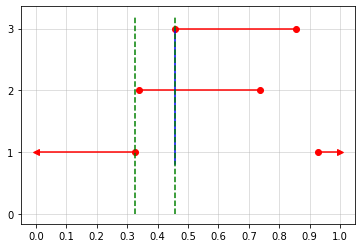

In [0]:
# Creating a circular society S, the spectrum is [0, 1]
S = CircularSociety( "S", 1)

p = 0.4 # length of the society

#   Adding sets 
left_endpoints = [0.9268, 0.3376, 0.4562]

for i, left_pt in enumerate(left_endpoints):
  S.addApprovalSet( "Set"+str(i), left_pt, (left_pt + p)%1 )

#  Displaying the circular society's information (name, is it uniform, the spectrum, number of voters, list of approval sets) 
S.printSocietyInfo()

#  Visualizing the circular society; each set is plotted horizontally (different y coordinates for different sets)
S.visualize( drawAgreement = True, drawPiercing = True )

#  Checking if the set is left-right alternating (returns True or False)
S.is_LR_alt()

# Finding the agreement number of the society
a, pos = S.findAgreementNumber( )
tau, piercingSet, x_value, Mat = S.findPiercingNumber()
print('Agreement Number: '+ str(a))
print('Location of max agreement: ' + str(pos))
print('Piercing Number: ' + str(tau))
print('Piercing Set: ')
print(piercingSet)

## Exploration 6: Multiple randomly-generated fixed-length societies

In [0]:
# ---
nSoc = 1000 # number of randomly-generated societies

N = 6 # number of approval sets
modulo = 1 # circumference of the circular society platform
p = 0.19
agreementNumList = np.zeros( nSoc )
piercingNumList = np.zeros( nSoc )


for i in range(0, nSoc):
  S = generateRandomFixedLengthSociety( "Fixed length society 1", N, modulo, p, tick=0.05 )
  #agreementNum, _ = S.findAgreementNumber()
  piercingNum, _, _, _ = S.findPiercingNumber()
  #agreementNumList[i] = agreementNum
  piercingNumList[i] = piercingNum

# print results & stats
print('Num sets: ', N)
print('Length: ', p)
print('Num societies: ', nSoc)
#print('Agreement Numbers: ', agreementNumList)
#print('Piercing Numbers: ', piercingNumList)

# piercing number stats
print('Piercing Numbers - Summary')
print('Min: ', np.min(piercingNumList))
print('Max: ', np.max(piercingNumList))
print('Mean: ', np.mean(piercingNumList))
print('Median: ', np.median(piercingNumList))
print('Fraction with tau = 2 :', np.sum( piercingNumList == 2) /nSoc )
print('Conjecture says: ', N*(N-1)/2*(1-2*p)*((2*p)**(N-2)) )
#print('conjecture says: ', N*(p**(N-1)) )

# test tau = 3
print('Fraction with tau = 3 :', np.sum( piercingNumList == 3) /nSoc )
print('Conjecture says: ', N*(N-1)*(N-2) /3/2 * ((1-3*p) ** 2)  * ((3*p)**(N-3)) )

# test tau = 4
print('Fraction with tau = 4 :', np.sum( piercingNumList == 4) /nSoc )
print('Conjecture says: ', N*(N-1)*(N-2)*(N-3) /4/3/2 * ((1-4*p) ** 3)  * ((4*p)**(N-4)) )

# test tau = 5
print('Fraction with tau = 5 :', np.sum( piercingNumList == 5) /nSoc )
print('Conjecture says: ', N*(N-1)*(N-2)*(N-3) * (N-2) /5/4/3/2 * ((1-5*p) ** 4)  * ((5*p)**(N-5)) )

Num sets:  6
Length:  0.19
Num societies:  1000
Piercing Numbers - Summary
Min:  1.0
Max:  4.0
Mean:  2.942
Median:  3.0
Fraction with tau = 2 : 0.184
Conjecture says:  0.193917648
Fraction with tau = 3 : 0.687
Conjecture says:  0.684843714
Fraction with tau = 4 : 0.128
Conjecture says:  0.11977113599999997
Fraction with tau = 5 : 0.0
Conjecture says:  7.125000000000025e-05


In [0]:
piercingNumList[ agreementNumList >= 5]

## Exploration 7: Testing the implementation of the "linear society piercing number algorithm" on circular societies

10
9


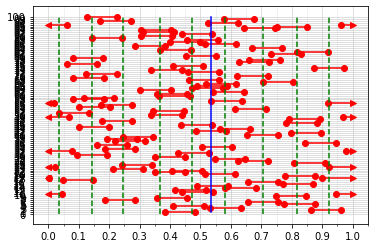

In [0]:
# Creating a circular society S, the spectrum is [0, 1]
N = 100 # number of approval sets
modulo = 1 # circumference of the circular society platform
p = 0.1 # length of the society

S = generateRandomFixedLengthSociety( "Fixed length society 1", N, modulo, p, tick=0.05 )

#  Visualizing the circular society; each set is plotted horizontally (different y coordinates for different sets)
S.visualize( drawAgreement = True, drawPiercing = True )

#  use the linear piercing algorithm
output = S.piercingAlgorithm( startingPoint=0)
print(len(output))

# find the actual piercing number
p, _, _, _ = S.findPiercingNumber()
print(p)

In [0]:
#  use the linear piercing algorithm, cutting the circle at a randomly chosen location x
S.printSocietyInfo()
print('------')

import random
x = random.uniform(0, 1)
print('x : ', x)
output = S.piercingAlgorithm( startingPoint=x)
print(np.array(output))
print(len(output))

Circular Society Name: Fixed length society 1
Spectrum: [0, 1].  (Note: we identify 0 = 1)
Number of Voters: 10
Approval Sets:
 Set 1: [0.11826599559245932, 0.3682659955924593]
 Set 2: [0.3459478228534085, 0.5959478228534085]
 Set 3: [0,0.18776004038305238] U [0.9377600403830523, 1]
 Set 4: [0.3411167632987965, 0.5911167632987965]
 Set 5: [0,0.13508836859867412] U [0.8850883685986741, 1]
 Set 6: [0.6418289266214466, 0.8918289266214466]
 Set 7: [0.17542104255074298, 0.425421042550743]
 Set 8: [0.4813445367719562, 0.7313445367719562]
 Set 9: [0.41322100073775747, 0.6632210007377575]
 Set 10: [0,0.12829538729937262] U [0.8782953872993726, 1]
------
x :  0.03661458676169649
[[0.12829538729937262 list(['Set 10', 'Set 5', 'Set 3', 'Set 1'])]
 [0.425421042550743 list(['Set 7', 'Set 4', 'Set 2', 'Set 9'])]
 [0.7313445367719562 list(['Set 8', 'Set 6'])]]
3


## Exploration 8: Multiple linear societies: check how often the linear piercing algorithm gives us the correct answer

In [0]:
nSoc = 100

# Creating a circular society S, the spectrum is [0, 1]
N = 100 # number of approval sets
modulo = 1 # circumference of the circular society platform
p = 0.3 # length of the society
tau_diff_list = np.zeros( nSoc ) # tau minus tau_actual

for i in range(0, nSoc):
  S = generateRandomFixedLengthSociety( "Fixed length society 1", N, modulo, p, tick=0.05 )
  #  use the linear piercing algorithm
  output = S.piercingAlgorithm( startingPoint=0)
  tau = len(output)
  # find the actual piercing number
  tau_actual, _, _, _ = S.findPiercingNumber()
  tau_diff_list[i] = tau - tau_actual

min_tau_diff = min(tau_diff_list)
max_tau_diff = max(tau_diff_list)
num_correct = len( tau_diff_list[tau_diff_list == 0] )
frac_correct = num_correct / nSoc

print('Minimum difference: ', min_tau_diff )
print('Maximum difference: ', max_tau_diff )
print('Fraction correct :', frac_correct )

Minimum difference:  0.0
Maximum difference:  1.0
Fraction correct : 0.96


## Exploration 9: Checking (k, m)-agreeability

In [0]:
# Creating a circular society S, the spectrum is [0, 1]
N = 10 # number of approval sets
modulo = 1 # circumference of the circular society platform
p = 0.2 # length of the society

S = generateRandomFixedLengthSociety( "Fixed length society 1", N, modulo, p, tick=0.05 )

#  Visualizing the circular society; each set is plotted horizontally (different y coordinates for different sets)
S.visualize( drawAgreement = True, drawPiercing = True )

is_kmagreeable, bad_m_sets = S.checkAgreeability(4, 9)
print(is_kmagreeable)
print(bad_m_sets)

NameError: ignored

In [0]:
is_kmagreeable, bad_m_sets = S.checkAgreeability(2, 3)
print(is_kmagreeable)
print(bad_m_sets)

NameError: ignored